# Sensitivity Analysis with the OpenCL RAMP model

### Import opencl modules

In [1]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
import re


from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Useful for connecting to this kernel
%connect_info

{
  "shell_port": 49454,
  "iopub_port": 49455,
  "stdin_port": 49456,
  "control_port": 49458,
  "hb_port": 49457,
  "ip": "127.0.0.1",
  "key": "d1dc0f2d-830ab484e9f9ce7b2af3fc9c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e429f901-584c-40b4-806e-8efca76f89b1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


### Setup params for all runs

Read the parameters file

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [2]:
PARAM_FILE = "healthy_population.yml"
PARAMETERS_FILE = os.path.join("../../","model_parameters", PARAM_FILE )
#PARAMETERS_FILE = os.path.join("../../","model_parameters", "week_earlier.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. You need to initilaise the model at least once to create the snapshot. The following says 'run in opencl mode and stop once initialisation has finished':

```
python microsim/main.py -ocl -init
```

In [3]:
PARAMS.place_hazard_multipliers

array([0.00555, 0.00555, 0.00555, 0.00555, 0.00555], dtype=float32)

In [4]:
PARAM_DIR = os.path.join("model_parameters", PARAM_FILE)
#PARAMS.presymptomatic_scale = 6.454166
#PARAMS.presymptomatic_shape = 22.38794 
#PARAMS.exposed_scale = 6.868067
#PARAMS.exposed_shape = 11.01902
#PARAMS.infection_mode = 8   #8 most common
#PARAMS.infection_log_scale = 0.17  #maximum should be 21 days
#PARAMS.individual_hazard_multipliers[1] = 0.44 #0.3#0.273
#PARAMS.place_hazard_multipliers = np.repeat(0.00555, 5)#0.0035#0.00385

#PARAMS.place_hazard_multipliers[0] = 0.988   #retail
#PARAMS.place_hazard_multipliers[1] = 0.972   #primary school
#PARAMS.place_hazard_multipliers[2] = 0.898   #secondary school
#PARAMS.place_hazard_multipliers[3] = 1   #home
#PARAMS.place_hazard_multipliers[4] = 0.005   #work

In [5]:
PARAMS.infection_mode
#PARAMS.infection_log_scale

8

In [6]:
%cd "~/Documents/ECEHH/COVID/RAMP-UA/"
!rm -f "microsim/opencl/snapshots/cache.npz"
!python microsim/main.py -ocl -init -p $PARAM_DIR
%cd "~/Documents/ECEHH/COVID/RAMP-UA/experiments/calibration/"

/Users/fionaspooner/Documents/ECEHH/COVID/RAMP-UA
Reading parameters file: model_parameters/healthy_population.yml. Any other model-related command-line arguments are being ignored
Running model with the following parameters:
	Parameters file: model_parameters/healthy_population.yml
	Scenario directory: BaselineScenario
	Initialise (and then exit?): True
	Number of iterations: 80
	Data dir: devon_data
	Using quant data? yes: QUANT_RAMP
	Outputting results?: True
	Outputting results at every iteration?: False
	Debug mode?: False
	Number of repetitions: 1
	Lockdown file: google_mobility_lockdown_daily_14_day_moving_average.csv
 	Use cache?: True
 	Use OpenCL version?: True
 	Use OpenCL GUI?: False
 	Use OpenCL GPU for processing?: False
 	Calibration parameters: {'hazard_individual_multipliers': {'presymptomatic': 1.0, 'asymptomatic': 0.44, 'symptomatic': 1.0}, 'hazard_location_multipliers': {'Retail': 1.0, 'PrimarySchool': 1.0, 'SecondarySchool': 1.0, 'Home': 1.0, 'Work': 1.0}, 'risk_mu

In [7]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

## Observation Data

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model. See the [README](./observation_data/README.md) for information about how these observations were obtained. They aren't the raw cases, it's actually a model that was fitted to the lagged cases. They need to be made cumulative as this is how they will be compared to the model.

In [8]:
# New per day:
gam_cases = pd.read_csv(os.path.join("../../", "gam_cases.csv"), header=0, names=["Day", "Cases"], )
gam_cases = pd.read_csv(os.path.join("../../gam_cases_new.csv"), header = 0, names=["Day", "Cases"],)

# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )

assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Total cases: 16246


## Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model

In [9]:
ITERATIONS = 100  # Number of iterations to run for
NUM_SEED_DAYS = 5  # Number of days to seed the population - don't think this is doing anything
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 10
USE_HEALTHIER_POP = True

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS, 
    repetitions = REPETITIONS, 
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    use_healthier_pop = USE_HEALTHIER_POP,
    store_detailed_counts = STORE_DETAILED_COUNTS, 
    parameters_file = PARAMETERS_FILE, 
    opencl_dir = OPENCL_DIR, 
    snapshot_filepath = SNAPSHOT_FILEPATH
)

In [10]:
# Results from the manually-calibrated model
manual_results = OpenCLRunner.run_opencl_model_multi(
    repetitions=REPETITIONS,  # Don't use the default, want slightly more robust results
    iterations=ITERATIONS,
    params=PARAMS,
    opencl_dir=OPENCL_DIR, 
    snapshot_filepath=SNAPSHOT_FILEPATH, 
    use_gpu=USE_GPU,
    store_detailed_counts=False,  # Get full info to plot age breakdowns
    multiprocess=False,
    random_ids=False,
    use_healthier_pop=USE_HEALTHIER_POP
)

manual_summaries = [x[0] for x in manual_results]
# Store the results as they can be useful as hypothetical observations to test some of the calibration algorithms
pseudo_observations = OpenCLRunner.get_cumulative_new_infections(manual_summaries)

Running models:   0%|          | 0/10 [00:00<?, ?it/s]

True
Running simulation 1.


Running models:  10%|█         | 1/10 [00:03<00:31,  3.46s/it]

Running simulation 2.


Running models:  20%|██        | 2/10 [00:06<00:27,  3.42s/it]

Running simulation 3.


Running models:  30%|███       | 3/10 [00:09<00:23,  3.29s/it]

Running simulation 4.


Running models:  40%|████      | 4/10 [00:12<00:19,  3.21s/it]

Running simulation 5.


Running models:  50%|█████     | 5/10 [00:15<00:15,  3.18s/it]

Running simulation 6.


Running models:  60%|██████    | 6/10 [00:19<00:12,  3.18s/it]

Running simulation 7.


Running models:  70%|███████   | 7/10 [00:22<00:09,  3.30s/it]

Running simulation 8.


Running models:  80%|████████  | 8/10 [00:26<00:06,  3.49s/it]

Running simulation 9.


Running models:  90%|█████████ | 9/10 [00:29<00:03,  3.45s/it]

Running simulation 10.


Running models: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]

.. finished, took 33.83s)


In [14]:
matrix_ifr = np.zeros(shape=(ITERATIONS*REPETITIONS,9))

for rep in range(REPETITIONS):
   row_ind = range((rep)*ITERATIONS,(rep+1)*ITERATIONS)
   matrix_ifr[row_ind,0] = rep+1
   matrix_ifr[row_ind,1] = range(1,ITERATIONS+1)
   matrix_ifr[row_ind,2] = manual_summaries[rep].total_counts[0]
   matrix_ifr[row_ind,3] = manual_summaries[rep].total_counts[1]
   matrix_ifr[row_ind,4] = manual_summaries[rep].total_counts[2]
   matrix_ifr[row_ind,5] = manual_summaries[rep].total_counts[3]
   matrix_ifr[row_ind,6] = manual_summaries[rep].total_counts[4]
   matrix_ifr[row_ind,7] = manual_summaries[rep].total_counts[5]
   matrix_ifr[row_ind,8] = manual_summaries[rep].total_counts[6]


csv_out = re.sub( ".yml","",PARAM_FILE)
csv_out = csv_out + "_" + str(REPETITIONS) + ".csv"
csv_path_out = os.path.join("../../","output", csv_out)

np.savetxt(csv_path_out, matrix_ifr, delimiter=",")


## Plot output summary data

### Total counts of disease status

In [15]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations
    
    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)
        
        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"], 
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")
        
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

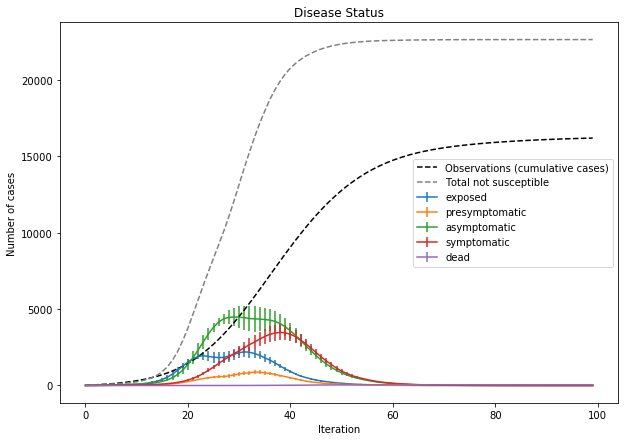

In [16]:
plot_summaries(summaries=manual_summaries, observations=OBSERVATIONS, plot_type="error_bars")

In [374]:
#plot_summaries(summaries=summaries, plot_type="lines")

### Disease statuses by age

In [202]:
plot_disease_status_by_age(manual_summaries)

NameError: name 'plot_disease_status_by_age' is not defined

In [ ]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

### Plot MSOA geodata

#### Load MSOA shapes

In [ ]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
import pandas as pd

data_dir = ("../../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

In [ ]:
import pandas as pd

def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep):
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True)
    plt.show()

### Plot disease status by MSOA for a given timestep and status

In [ ]:
disease_status = "exposed"

plot_msoa_choropleth(devon_msoa_shapes, manual_summaries[1], disease_status, 99)